In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper/use_pharma_false
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper/use_pharma_false/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/503 [00:00<?, ?mol/s]

[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:20:34] Can't kekuliz

503


503

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...
...,...
498,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1C1N(C)C(=O)N...
499,COc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)...
500,CC1CC2C(CC1C1N(C)C(=O)NC(=O)C13CC3)C2OC1=NC=CC...
501,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)[nH]...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...
...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

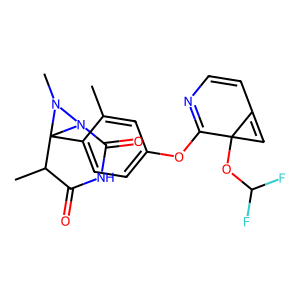

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0          [c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]
1               [c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]
2      [c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...
3      [O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...
4        [O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]
                             ...                        
227    [O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...
228                [c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]
229    [O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...
230     [O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]
231    [c1ccccc1, C1=CC2=CC2C=N1, O=C1NC(=O)N2CC2C2NC12]
Name: ring_sytems, Length: 232, dtype: object

In [12]:
df.ring_sytems.values

array([list(['c1ccccc1', 'C1=CC2=CC2C=N1', 'O=C1CC2NN2C(=O)N1']),
       list(['c1ccccc1', 'c1ccncc1', 'O=C1NC(=O)C2CNC2N1']),
       list(['c1ccccc1', 'C1CC2CC3(CO3)C2CN1', 'O=c1cc[nH]c(=O)[nH]1']),
       list(['O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142', 'c1ccncc1']),
       list(['O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312', 'c1ccncc1']),
       list(['c1ccccc1', 'C1CCN2CC2C1', 'O=C1CC2NN2C(=O)N1']),
       list(['O=C1NC(=O)C23CN2CCC2CCCC4N5C24C53N1', 'C1=CC2=CC2C=N1']),
       list(['c1ccccc1', 'C1CCN2CC2C1', 'O=c1cc[nH]c(=O)[nH]1']),
       list(['O=C1NCC2(CC2)C(=O)N1', 'c1ccccc1', 'C1=CC2=CC2C=N1']),
       list(['c1ccccc1', 'C1=CC2=CC2C=N1', 'O=C1NCC2(CN2)C(=O)N1']),
       list(['O=C1CC2([N+]3=C4C=CC=CC432)[N+]2(CC2)C(=O)N1', 'c1ccncc1']),
       list(['c1ccccc1', 'C1=CC2=CC2C=N1', 'O=c1cc[nH]c(=O)[nH]1']),
       list(['c1ccccc1', 'c1ccncc1', 'O=c1cc[nH]c(=O)[nH]1']),
       list(['O=c1cc[nH]c(=O)[nH]1', 'c1ccccc1', 'C1=CC2=CC2C=N1']),
       list(['c1ccccc1', 'C1=CC2=CC2C=N1', 

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,138
3,c1ccncc1,106
1,C1=CC2=CC2C=N1,81
6,O=c1cc[nH]c(=O)[nH]1,60
14,O=C1CCNC(=O)N1,22
...,...,...
85,C1=CC2=C3CC23C=C1,1
86,O=C1NC(=O)C2=[NH+][N+]23C(=[NH+]1)C31CCCCC1,1
87,O=c1[nH]c2c(c(=O)[nH]1)CCCc1ccccc1-2,1
96,C1C2CC12,1


View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0      [(c1ccccc1, 2568039), (C1=CC2=CC2C=N1, 0), (O=...
1      [(c1ccccc1, 2568039), (c1ccncc1, 275595), (O=C...
2      [(c1ccccc1, 2568039), (C1CC2CC3(CO3)C2CN1, 0),...
3      [(O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]14...
4      [(O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, 0), (c1...
                             ...                        
227    [(O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, 0), (C1...
228    [(c1ccccc1, 2568039), (c1ccncc1, 275595), (O=C...
229    [(O=C1CC2(NC(=O)N1)N1C3CCCCC312, 0), (C1=CC2=C...
230    [(O=c1cc[nH]c(=O)[nH]1, 22444), (C1C2CC2NC2CC1...
231    [(c1ccccc1, 2568039), (C1=CC2=CC2C=N1, 0), (O=...
Name: mol, Length: 232, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0
...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0


In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Omitted undefined stereo

[16:21:09] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:2

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...
...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...


How many of them have ring system?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...
...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...


In [22]:
filtered_df_ring_freq = df[df.min_freq > 100]
len(filtered_df_ring_freq)

24

### How many of them could pass PAINS filter?

Get a list of rules

In [23]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [24]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [25]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [26]:
reos.pandas_mols(df.mol)

  0%|          | 0/232 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
227,ok,ok
228,ok,ok
229,ok,ok
230,ok,ok


In [27]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/232 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,ok,ok
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,ok,ok
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,ok,ok
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,ok,ok
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,ok,ok
...,...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,ok,ok
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,ok,ok
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,ok,ok
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,ok,ok


Test all filters from rd filters

In [28]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/232 [00:00<?, ?it/s]

Glaxo 0.45689655172413796 ['Glaxo'] 106


  0%|          | 0/232 [00:00<?, ?it/s]

Dundee 0.3879310344827586 ['Dundee'] 90


  0%|          | 0/232 [00:00<?, ?it/s]

BMS 0.40086206896551724 ['BMS'] 93


  0%|          | 0/232 [00:00<?, ?it/s]

SureChEMBL 0.375 ['SureChEMBL'] 87


  0%|          | 0/232 [00:00<?, ?it/s]

MLSMR 0.3577586206896552 ['MLSMR'] 83


  0%|          | 0/232 [00:00<?, ?it/s]

Inpharmatica 0.16379310344827586 ['Inpharmatica'] 38


  0%|          | 0/232 [00:00<?, ?it/s]

LINT 0.33620689655172414 ['LINT'] 78


### How many of them could pass filters suggested by Dr.Reymond?

In [29]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,False
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,False
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,False
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,False
...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,False
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,False
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,True


In [30]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True
5,Cc1cc(OC2C3C(OC(F)F)CCCN23)ccc1C12C(C)C(=O)N(C...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271460>,"[c1ccccc1, C1CCN2CC2C1, O=C1CC2NN2C(=O)N1]",C1CCN2CC2C1,0,InChI=1S/C21H26F2N4O4/c1-11-10-13(30-18-16-15(...,True
7,Cc1cc(OC2C3C(OC(F)F)CCCN23)ccc1-c1c(C)c(=O)n(C...,<rdkit.Chem.rdchem.Mol object at 0x7550cae76490>,"[c1ccccc1, C1CCN2CC2C1, O=c1cc[nH]c(=O)[nH]1]",C1CCN2CC2C1,0,InChI=1S/C21H25F2N3O4/c1-11-10-13(29-19-17-15(...,True
12,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271620>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,22444,InChI=1S/C19H17F2N3O4/c1-10-9-12(27-17-14(28-1...,True
16,Cc1cc(OC2C3C(OC(F)F)CCCN23)ccc1C1N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2717e0>,"[c1ccccc1, C1CCN2CC2C1, O=C1CCNC(=O)N1]",C1CCN2CC2C1,0,InChI=1S/C20H25F2N3O5/c1-10-9-11(29-16-14-13(3...,True
...,...,...,...,...,...,...,...
216,CC1=C(c2ccc(Oc3ncccc3OC(F)F)cc2C)[N+]2(CC2)C(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca276ff0>,"[O=C1C=C[N+]2(CC2)C(=O)N1, c1ccccc1, c1ccncc1]",O=C1C=C[N+]2(CC2)C(=O)N1,0,InChI=1S/C21H20F2N3O4/c1-12-11-14(29-18-16(30-...,True
218,Cc1cc(Oc2ncccc2OC(F)F)cc2c1N2C12C(C)C(=O)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2770d0>,"[c1ccc2c(c1)N2, c1ccncc1, O=C1CC2NC2C(=O)N1]",c1ccc2c(c1)N2,0,InChI=1S/C21H20F2N4O4/c1-10-8-12(30-17-14(31-2...,True
221,Cc1cc(OC2NCC3CC3C2OC(F)F)ccc1-c1c(C)c(=O)[nH]c...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277220>,"[c1ccccc1, C1CC2CC2CN1, O=c1cc[nH]c(=O)[nH]1]",C1CC2CC2CN1,49,InChI=1S/C20H23F2N3O4/c1-9-6-12(28-18-16(29-19...,True
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True


### How many of them could pass RO5?

In [31]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,False,True
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True,True
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,False,True
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,False,True
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,False,True
...,...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,False,True
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True,True
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,False,True
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,True,True


In [32]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,False,True
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True,True
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,False,True
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,False,True
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,False,True
...,...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,False,True
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True,True
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,False,True
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [33]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(c1ccccc1, 21243538754), (C1=CC2=CC2C=N1, 0),...
1      [(c1ccccc1, 21243538754), (c1ccncc1, 997562007...
2      [(c1ccccc1, 21243538754), (C1CC2CC3(CO3)C2CN1,...
3      [(O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]14...
4      [(O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, 0), (c1...
                             ...                        
227    [(O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, 0), (C1...
228    [(c1ccccc1, 21243538754), (c1ccncc1, 997562007...
229    [(O=C1CC2(NC(=O)N1)N1C3CCCCC312, 0), (C1=CC2=C...
230    [(O=c1cc[nH]c(=O)[nH]1, 11175854), (C1C2CC2NC2...
231    [(c1ccccc1, 21243538754), (C1=CC2=CC2C=N1, 0),...
Name: mol, Length: 232, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,False,True
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True,True
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,False,True
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,False,True
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,False,True
...,...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,False,True
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True,True
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,False,True
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,True,True


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [37]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
12,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271620>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C19H17F2N3O4/c1-10-9-12(27-17-14(28-1...,True,True
24,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1C1N(C)C(=O)NC(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271b60>,"[c1ccccc1, c1ccncc1, O=C1NCC2(CC2)C(=O)N1]",O=C1NCC2(CC2)C(=O)N1,10776,InChI=1S/C21H19F2N3O4/c1-11-10-12(30-18-14(4-3...,True,True
26,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271c40>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(29-19-14(5-4-...,True,True
39,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2721f0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C21H19F2N3O4/c1-11-10-13(18(27)16-15(...,True,True
40,Cc1cc(Oc2nccc(C=O)c2OC(F)F)ccc1-c1c(C)c(=O)[nH...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272260>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O5/c1-10-8-13(29-18-16(30-1...,True,True
49,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272650>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H19F2N3O4/c1-11-10-13(28-17-15(29-...,True,True
63,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C(C#N)C(=O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca272c70>,"[c1ccccc1, c1ccncc1, O=C1CCNC(=O)N1]",O=C1CCNC(=O)N1,41697648,InChI=1S/C19H16F2N4O4/c1-10-8-11(28-17-14(29-1...,True,True
71,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272ff0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(17(26)15-14(2...,True,True
78,Cc1cc(OC2NCC3CC3C2OC(F)F)ccc1-c1c(N(C)C)c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x7550ca273300>,"[c1ccccc1, C1CC2CC2CN1, O=c1cc[nH]c(=O)[nH]1]",C1CC2CC2CN1,179514,InChI=1S/C22H28F2N4O4/c1-11-8-13(31-19-18(32-2...,True,True
82,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C#N)c(=O)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2734c0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H16F2N4O4/c1-11-9-12(29-17-15(30-1...,True,True


In [36]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
12,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271620>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C19H17F2N3O4/c1-10-9-12(27-17-14(28-1...,True,True
24,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1C1N(C)C(=O)NC(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271b60>,"[c1ccccc1, c1ccncc1, O=C1NCC2(CC2)C(=O)N1]",O=C1NCC2(CC2)C(=O)N1,10776,InChI=1S/C21H19F2N3O4/c1-11-10-12(30-18-14(4-3...,True,True
26,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271c40>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(29-19-14(5-4-...,True,True
39,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2721f0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C21H19F2N3O4/c1-11-10-13(18(27)16-15(...,True,True
40,Cc1cc(Oc2nccc(C=O)c2OC(F)F)ccc1-c1c(C)c(=O)[nH...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272260>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O5/c1-10-8-13(29-18-16(30-1...,True,True
49,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272650>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H19F2N3O4/c1-11-10-13(28-17-15(29-...,True,True
63,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C(C#N)C(=O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca272c70>,"[c1ccccc1, c1ccncc1, O=C1CCNC(=O)N1]",O=C1CCNC(=O)N1,41697648,InChI=1S/C19H16F2N4O4/c1-10-8-11(28-17-14(29-1...,True,True
71,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272ff0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(17(26)15-14(2...,True,True
78,Cc1cc(OC2NCC3CC3C2OC(F)F)ccc1-c1c(N(C)C)c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x7550ca273300>,"[c1ccccc1, C1CC2CC2CN1, O=c1cc[nH]c(=O)[nH]1]",C1CC2CC2CN1,179514,InChI=1S/C22H28F2N4O4/c1-11-8-13(31-19-18(32-2...,True,True
82,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C#N)c(=O)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2734c0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H16F2N4O4/c1-11-9-12(29-17-15(30-1...,True,True


In [38]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
12,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271620>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C19H17F2N3O4/c1-10-9-12(27-17-14(28-1...,True,True
24,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1C1N(C)C(=O)NC(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271b60>,"[c1ccccc1, c1ccncc1, O=C1NCC2(CC2)C(=O)N1]",O=C1NCC2(CC2)C(=O)N1,10776,InChI=1S/C21H19F2N3O4/c1-11-10-12(30-18-14(4-3...,True,True
26,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271c40>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(29-19-14(5-4-...,True,True
39,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2721f0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C21H19F2N3O4/c1-11-10-13(18(27)16-15(...,True,True
40,Cc1cc(Oc2nccc(C=O)c2OC(F)F)ccc1-c1c(C)c(=O)[nH...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272260>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O5/c1-10-8-13(29-18-16(30-1...,True,True
49,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272650>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H19F2N3O4/c1-11-10-13(28-17-15(29-...,True,True
63,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C(C#N)C(=O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca272c70>,"[c1ccccc1, c1ccncc1, O=C1CCNC(=O)N1]",O=C1CCNC(=O)N1,41697648,InChI=1S/C19H16F2N4O4/c1-10-8-11(28-17-14(29-1...,True,True
71,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272ff0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H17F2N3O4/c1-10-9-12(17(26)15-14(2...,True,True
78,Cc1cc(OC2NCC3CC3C2OC(F)F)ccc1-c1c(N(C)C)c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x7550ca273300>,"[c1ccccc1, C1CC2CC2CN1, O=c1cc[nH]c(=O)[nH]1]",C1CC2CC2CN1,179514,InChI=1S/C22H28F2N4O4/c1-11-8-13(31-19-18(32-2...,True,True
82,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C#N)c(=O)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2734c0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,11175854,InChI=1S/C20H16F2N4O4/c1-11-9-12(29-17-15(30-1...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [39]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(c1ccccc1, 503413992), (C1=CC2=CC2C=N1, 0), (...
1      [(c1ccccc1, 503413992), (c1ccncc1, 110130832),...
2      [(c1ccccc1, 503413992), (C1CC2CC3(CO3)C2CN1, 0...
3      [(O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]14...
4      [(O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, 0), (c1...
                             ...                        
227    [(O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, 0), (C1...
228    [(c1ccccc1, 503413992), (c1ccncc1, 110130832),...
229    [(O=C1CC2(NC(=O)N1)N1C3CCCCC312, 0), (C1=CC2=C...
230    [(O=c1cc[nH]c(=O)[nH]1, 494266), (C1C2CC2NC2CC...
231    [(c1ccccc1, 503413992), (C1=CC2=CC2C=N1, 0), (...
Name: mol, Length: 232, dtype: object

In [40]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Cc1cc(OC2=NC=CC3=CC32OC(F)F)ccc1C12C(C)C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271230>,"[c1ccccc1, C1=CC2=CC2C=N1, O=C1CC2NN2C(=O)N1]",C1=CC2=CC2C=N1,0,InChI=1S/C20H18F2N4O4/c1-10-8-13(29-16-19(30-1...,False,True
1,Cc1cc(Oc2ncccc2OC(F)F)ccc1N1C(C)C2C(=O)NC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2712a0>,"[c1ccccc1, c1ccncc1, O=C1NC(=O)C2CNC2N1]",O=C1NC(=O)C2CNC2N1,0,InChI=1S/C20H20F2N4O4/c1-10-9-12(29-17-14(30-1...,True,True
2,Cc1cc(OC2NCCC3CC4(OC4(F)F)C32)ccc1-c1c(C)c(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271310>,"[c1ccccc1, C1CC2CC3(CO3)C2CN1, O=c1cc[nH]c(=O)...",C1CC2CC3(CO3)C2CN1,0,InChI=1S/C22H25F2N3O4/c1-11-9-14(5-6-15(11)17-...,False,True
3,CN1C(=O)NC(=O)C2(CC2)C12C1=CC=C(Oc3ncccc3OC(F)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271380>,[O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142...,O=C1NC(=O)C2(CC2)C2(N1)C1=CC=CC3=CC34C[N+]142,0,InChI=1S/C21H16F2N4O4/c1-26-18(29)25-16(28)19(...,False,True
4,CC1CC(Oc2ncccc2OC(F)F)CC2N3C12C31N(C)C(=O)NC(=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2713f0>,"[O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312, c1ccncc1]",O=C1NC(=O)C2(CC2)C2(N1)N1C3CCCCC312,0,InChI=1S/C20H22F2N4O4/c1-10-8-11(29-14-12(30-1...,False,True
...,...,...,...,...,...,...,...,...
227,CCN1C(=O)NC(=O)C23C[N+]24C2(CCC(OC5=[N+]=CCC6=...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2774c0>,"[O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1, C1=[N+]=...",O=C1NC(=O)C23C[N+]24C2(CCCCC2)C34N1,0,InChI=1S/C21H23F2N4O4/c1-3-26-17(29)25-14(28)2...,False,True
228,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C2CCOC2(O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca277530>,"[c1ccccc1, c1ccncc1, O=C1NCC2CCOC2N1]",O=C1NCC2CCOC2N1,0,InChI=1S/C20H21F2N3O5/c1-11-10-12(29-17-15(30-...,True,True
229,CC1CC(OC2=NC=CC3=CC32OC(F)F)CC2N3C12C31C(C23CC...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2775a0>,"[O=C1CC2(NC(=O)N1)N1C3CCCCC312, C1=CC2=CC2C=N1...",O=C1CC2(NC(=O)N1)N1C3CCCCC312,0,InChI=1S/C23H24F2N4O4/c1-10-5-13(32-17-21(33-1...,False,True
230,Cc1c(N2C3CC3C(Oc3ncccc3OC(F)F)C3C(C)C32)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca277610>,"[O=c1cc[nH]c(=O)[nH]1, C1C2CC2NC2CC12, c1ccncc1]",C1C2CC2NC2CC12,0,InChI=1S/C21H24F2N4O4/c1-9-14-15(9)27(18-10(2)...,True,True


In [41]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
12,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271620>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C19H17F2N3O4/c1-10-9-12(27-17-14(28-1...,True,True
26,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca271c40>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H17F2N3O4/c1-10-9-12(29-19-14(5-4-...,True,True
39,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2721f0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C21H19F2N3O4/c1-11-10-13(18(27)16-15(...,True,True
40,Cc1cc(Oc2nccc(C=O)c2OC(F)F)ccc1-c1c(C)c(=O)[nH...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272260>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H17F2N3O5/c1-10-8-13(29-18-16(30-1...,True,True
49,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)c(=O)n(C)c(=O...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272650>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H19F2N3O4/c1-11-10-13(28-17-15(29-...,True,True
63,Cc1cc(Oc2ncccc2OC(F)F)ccc1C1C(C#N)C(=O)NC(=O)N1C,<rdkit.Chem.rdchem.Mol object at 0x7550ca272c70>,"[c1ccccc1, c1ccncc1, O=C1CCNC(=O)N1]",O=C1CCNC(=O)N1,203277,InChI=1S/C19H16F2N4O4/c1-10-8-11(28-17-14(29-1...,True,True
71,Cc1cc(C(=O)c2ncccc2OC(F)F)ccc1-c1c(C)c(=O)[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7550ca272ff0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H17F2N3O4/c1-10-9-12(17(26)15-14(2...,True,True
82,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C#N)c(=O)n(C)c(...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2734c0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H16F2N4O4/c1-11-9-12(29-17-15(30-1...,True,True
87,Cc1cc(C(O)c2ncccc2OC(F)F)ccc1-c1c(C#N)c(=O)[nH...,<rdkit.Chem.rdchem.Mol object at 0x7550ca2736f0>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C20H16F2N4O4/c1-10-8-11(17(27)15-14(3...,True,True
88,Cc1cc(Oc2ncccc2C(=O)C(F)F)ccc1-c1c(C)c(=O)n(C)...,<rdkit.Chem.rdchem.Mol object at 0x7550ca273760>,"[c1ccccc1, c1ccncc1, O=c1cc[nH]c(=O)[nH]1]",O=c1cc[nH]c(=O)[nH]1,494266,InChI=1S/C21H19F2N3O4/c1-11-10-13(30-19-15(6-5...,True,True
